In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor, StackingRegressor
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.feature_selection import SelectFromModel
from xgboost import XGBRegressor
import xgboost as xgb
import warnings
from sklearn.preprocessing import PolynomialFeatures
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_log_error
from sklearn.base import clone
warnings.filterwarnings('ignore')

# Preprocessing

In [2]:
COLUMNS_TO_NORMALIZE = ['Weight', 'Height', 'Age', 'Duration', 'Heart_Rate']
# COLUMNS_TO_NORMALIZE = ['Age', 'body_temp']

In [3]:
def encode_sex_column(df, drop_original=True):
   
    df = df.copy()
    sex_mapping = {'female': 0, 'male': 1, 'Male': 1}
    df['Sex_encoded'] = df['Sex'].map(sex_mapping)
    
    if drop_original and 'Sex' in df.columns:
        df.drop('Sex', axis=1, inplace=True)
    
    return df

def handle_outliers(df, column, method='cap', debug=True):

    if column not in df.columns or not pd.api.types.is_numeric_dtype(df[column]):
        return df

    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Identify outliers
    outliers_low = df[df[column] < lower_bound]
    outliers_high = df[df[column] > upper_bound]
    total_outliers = len(outliers_low) + len(outliers_high)
    
    if debug:
        print(f"\nColumn: {column}")
        print(f"Q1: {Q1:.2f}, Q3: {Q3:.2f}, IQR: {IQR:.2f}")
        print(f"Lower bound: {lower_bound:.2f}, Upper bound: {upper_bound:.2f}")
        print(f"Outliers below lower bound: {len(outliers_low)} ({len(outliers_low)/len(df)*100:.2f}%)")
        print(f"Outliers above upper bound: {len(outliers_high)} ({len(outliers_high)/len(df)*100:.2f}%)")
        print(f"Total outliers: {total_outliers} ({total_outliers/len(df)*100:.2f}%)")
        
        if total_outliers == 0:
            print(f"No outliers detected in column '{column}'")
        else:
            if len(outliers_low) > 0:
                print(f"Lower outlier values: {outliers_low[column].values}")
            if len(outliers_high) > 0:
                print(f"Upper outlier values: {outliers_high[column].values}")
    
    # Handle outliers
    if method == 'cap':
        original_df = df.copy()
        df[column] = df[column].clip(lower_bound, upper_bound)
        
        if debug and total_outliers > 0:
            print(f"Method: Capping outliers to bounds")
            print(f"Values changed: {(original_df[column] != df[column]).sum()}")
    elif method == 'remove':
        original_len = len(df)
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
        
        if debug and total_outliers > 0:
            print(f"Method: Removing outlier rows")
            print(f"Rows removed: {original_len - len(df)}")
    
    return df

def preprocess_with_outlier_handling(df, debug=True):

    df_copy = df.copy()
    
    if debug:
        print("\n=== OUTLIER DETECTION AND HANDLING ===")
        
    outliers_found = False
    
    for col in df.select_dtypes(include=['float64', 'int64']).columns:
        if col != 'Calories':  
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            
            has_outliers = ((df[col] < lower_bound) | (df[col] > upper_bound)).any()
            
            if has_outliers:
                outliers_found = True
            
            # Handle outliers
            df_copy = handle_outliers(df_copy, col, method='cap', debug=debug)
    
    if debug and not outliers_found:
        print("\nNo outliers were found in any column.")
    
    return df_copy

def normalize_features(df):
    df_norm = df.copy()

    for column in COLUMNS_TO_NORMALIZE:
        if column in df_norm.columns and pd.api.types.is_numeric_dtype(df_norm[column]):
            min_val = df_norm[column].min()
            max_val = df_norm[column].max()
            df_norm[f"{column}_normalized"] = (df_norm[column] - min_val) / (max_val - min_val)

    skewed_features = []
    for col in df_norm.select_dtypes(include=['float64', 'int64']).columns:
        skewness = df_norm[col].skew()
        if abs(skewness) > 1.0:
            skewed_features.append(col)

    if skewed_features:
        pt = PowerTransformer(method='yeo-johnson', standardize=True)
        df_norm[skewed_features] = pt.fit_transform(df_norm[skewed_features])

    return df_norm

# Feature Engineering

In [7]:
def create_features(df):

    df = df.copy()
    
    # Weight per Age
    df['Weight_per_Age'] = df['Weight'] / (df['Age'] + 1)
    
    # HeartRate per Weight
    df['HeartRate_per_kg'] = df['Heart_Rate'] / df['Weight']
    
    # Duration Per Age
    df['Duration_per_age'] = df['Duration'] / (df['Age'] + 1)
    
    # Duration * Heart Rate
    df['Duration_heart_rate'] = df['Duration'] * df['Heart_Rate']
    
    # Intensity
    df['Duration_per_weight'] = df['Duration'] / df['Weight']
    
    # All Durations add and multi
    df['duration_sum'] = df['Duration_per_weight'] + df['Duration_heart_rate'] + df['Duration_per_age']
    df['duration_multi'] = df['Duration_per_weight'] * df['Duration_heart_rate'] * df['Duration_per_age']
    
    # Converting Height in Meters
    df['Height'] = df['Height'] / 100
    
    # Creating new column 'BMI'
    df['BMI'] = df['Weight'] / (df['Height'] ** 2)
    df['BMI'] = df['BMI'].round(2)
    
    # Mapping Genders if 'Sex' column exists and is not already numeric
    if 'Sex' in df.columns and df['Sex'].dtype == 'object':
        map = {'male': 0, 'female': 1, 'Male': 0, 'Female': 1}
        df['Sex'] = df['Sex'].map(map)
    
    return df

def create_advanced_features(df):
    df = df.copy()
    
    # More physiological features
    df['Body_Temp_Heart_Rate'] = df['Body_Temp'] * df['Heart_Rate']
    df['Workout_Intensity'] = (df['Heart_Rate'] * df['Duration']) / df['Weight']
    
    # Age-related features
    df['Age_Group'] = pd.cut(df['Age'], bins=[0, 30, 45, 60, 100], labels=[0, 1, 2, 3])
    
    # BMI categories
    df['BMI_Category'] = pd.cut(df['BMI'], 
                                bins=[0, 18.5, 25, 30, 100], 
                                labels=[0, 1, 2, 3])  # Underweight, Normal, Overweight, Obese
    
    # Target encoding for categorical features
    if 'Calories' in df.columns:  # Only for training data
        means = df.groupby('BMI_Category')['Calories'].mean()
        df['BMI_Category_Target'] = df['BMI_Category'].map(means)
        
        means = df.groupby('Age_Group')['Calories'].mean()
        df['Age_Group_Target'] = df['Age_Group'].map(means)
    
    # Interaction terms
    df['Height_Weight_Ratio'] = df['Height'] / df['Weight']
    df['Weight_Heart_Rate'] = df['Weight'] * df['Heart_Rate']
    
    return df

def add_polynomial_features(train, test, top_features, degree=2):
    X_train = train.copy()
    X_test = test.copy()

    if len(top_features) > 20:
        top_features = top_features[:20]

    X_top_train = X_train[top_features]
    X_top_test = X_test[top_features]

    poly = PolynomialFeatures(degree=degree, include_bias=False, interaction_only=True)
    poly.fit(X_top_train)

    poly_features_train = poly.transform(X_top_train)
    poly_features_test = poly.transform(X_top_test)

    feature_names = poly.get_feature_names_out(top_features)
    poly_df_train = pd.DataFrame(poly_features_train, columns=feature_names, index=train.index)
    poly_df_test = pd.DataFrame(poly_features_test, columns=feature_names, index=test.index)

    # Only get interaction features (not the original features)
    interaction_features = [col for col in poly_df_train.columns if ' ' in col]
    
    # Add these interaction features to the original dataframes
    for col in interaction_features:
        X_train[col] = poly_df_train[col]
        X_test[col] = poly_df_test[col]

    return X_train, X_test

def create_domain_interactions(df):
    """
    Create domain-specific interaction features based on physiology.
    Accepts one dataframe and returns the dataframe with added features.
    """
    df = df.copy()
    
    # 1. BMI * Duration (effect of body composition on calorie burn over time)
    if 'BMI' in df.columns:
        df['BMI_Duration'] = df['BMI'] * df['Duration']
    
    # 2. Heart Rate * Body Temp * Duration (combined effect on calorie expenditure)
    df['HR_Temp_Duration'] = df['Heart_Rate'] * df['Body_Temp'] * df['Duration']
    
    # 3. Age effect on heart rate response
    df['Age_HR_Effect'] = df['Heart_Rate'] / (220 - df['Age'])
    
    # 4. Weight impact on calorie burn rate
    df['Weight_HR_Effect'] = df['Weight'] * df['Heart_Rate'] / 100
    
    # 5. Thermal effect on metabolism
    df['Thermal_Effect'] = (df['Body_Temp'] - 37) * df['Duration'] * df['Weight']
    
    # 6. Sex-specific calorie expenditure factors (if sex data available)
    if 'Sex_encoded' in df.columns:
        # Different calorie expenditure based on sex, weight, and heart rate
        df['Sex_Weight_Effect'] = df['Sex_encoded'] * df['Weight'] * 0.1 + (1-df['Sex_encoded']) * df['Weight'] * 0.12
        df['Sex_HR_Effect'] = df['Sex_encoded'] * df['Heart_Rate'] * 0.8 + (1-df['Sex_encoded']) * df['Heart_Rate']
    
    return df

In [5]:
def select_optimal_features(X, y, threshold=0.001):
    from sklearn.feature_selection import RFECV, SelectFromModel
    from sklearn.ensemble import RandomForestRegressor

    rf = XGBRegressor(n_estimators=100, random_state=42)
    rf.fit(X, y)

    importances = pd.DataFrame({
        'feature': X.columns,
        'importance': rf.feature_importances_
    }).sort_values('importance', ascending=False)

    selector = SelectFromModel(rf, threshold=threshold, prefit=True)
    X_selected = selector.transform(X)
    selected_features = X.columns[selector.get_support()]

    print(f"Selected {len(selected_features)} out of {X.shape[1]} features")

    # Recursive feature elimination with cross-validation
    if X.shape[1] < 50:
        rfecv = RFECV(estimator=rf, step=1, cv=5, scoring='r2', n_jobs=-1)
        rfecv.fit(X, y)
        X_rfecv = rfecv.transform(X)
        rfecv_features = X.columns[rfecv.support_]
        print(f"RFECV selected {len(rfecv_features)} features")
        return X_rfecv, rfecv_features

    return X_selected, selected_features

# Data preparation

In [6]:
def load_data():
    data_dir = '../input/'

    train = pd.read_csv(data_dir + 'train.csv', index_col="id")
    test = pd.read_csv(data_dir + 'test.csv', index_col="id")
    return train, test

In [18]:
def data_preparation(train, test, target_column='Calories'):
    X = train.copy()
    y = X.pop(target_column)
    X_test = test.copy()

    X_combined = pd.concat([X, X_test])

    # Preprocessing
    X_combined = encode_sex_column(X_combined)
    X_combined = preprocess_with_outlier_handling(X_combined)
    X_combined = create_features(X_combined)
    X_combined = create_domain_interactions(X_combined)
    # X_combined = normalize_features(X_combined)

    
    # Periksa dan tangani kolom non-numerik
    for col in X_combined.columns:
        if not pd.api.types.is_numeric_dtype(X_combined[col]):
            print(f"Warning: Kolom {col} bukan numerik.")
            X_combined[col] = pd.to_numeric(X_combined[col], errors='coerce')

    # Periksa kolom dengan variansi nol
    for col in X_combined.columns:
        if X_combined[col].nunique() <= 1:
            print(f"Warning: Kolom {col} memiliki variansi 0. Menghapus kolom...")
            X_combined = X_combined.drop(columns=[col])

   # Pemisahan data
    train_processed = X_combined.iloc[:len(train)].copy()
    train_processed[target_column] = y.values
    test_processed = X_combined.iloc[len(train):].copy()

    return train_processed, test_processed

In [19]:
train, test = load_data()
train_processed, test_processed = data_preparation(train, test)


=== OUTLIER DETECTION AND HANDLING ===

Column: Age
Q1: 28.00, Q3: 52.00, IQR: 24.00
Lower bound: -8.00, Upper bound: 88.00
Outliers below lower bound: 0 (0.00%)
Outliers above upper bound: 0 (0.00%)
Total outliers: 0 (0.00%)
No outliers detected in column 'Age'

Column: Height
Q1: 164.00, Q3: 185.00, IQR: 21.00
Lower bound: 132.50, Upper bound: 216.50
Outliers below lower bound: 3 (0.00%)
Outliers above upper bound: 17 (0.00%)
Total outliers: 20 (0.00%)
Lower outlier values: [129. 126. 127.]
Upper outlier values: [217. 217. 222. 222. 217. 218. 217. 218. 217. 222. 218. 217. 217. 217.
 219. 217. 218.]
Method: Capping outliers to bounds
Values changed: 20

Column: Weight
Q1: 63.00, Q3: 87.00, IQR: 24.00
Lower bound: 27.00, Upper bound: 123.00
Outliers below lower bound: 0 (0.00%)
Outliers above upper bound: 10 (0.00%)
Total outliers: 10 (0.00%)
Upper outlier values: [132. 128. 128. 128. 124. 126. 126. 132. 126. 126.]
Method: Capping outliers to bounds
Values changed: 10

Column: Duratio

In [20]:
# Split train_processed into features and target

X_train = train_processed.drop(columns=['Calories'])
y_train = train_processed['Calories']
X_test = test_processed.copy()

In [22]:
X_train.shape

(750000, 22)

In [23]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 750000 entries, 0 to 749999
Data columns (total 22 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Age                  750000 non-null  int64  
 1   Height               750000 non-null  float64
 2   Weight               750000 non-null  float64
 3   Duration             750000 non-null  float64
 4   Heart_Rate           750000 non-null  float64
 5   Body_Temp            750000 non-null  float64
 6   Sex_encoded          750000 non-null  int64  
 7   Weight_per_Age       750000 non-null  float64
 8   HeartRate_per_kg     750000 non-null  float64
 9   Duration_per_age     750000 non-null  float64
 10  Duration_heart_rate  750000 non-null  float64
 11  Duration_per_weight  750000 non-null  float64
 12  duration_sum         750000 non-null  float64
 13  duration_multi       750000 non-null  float64
 14  BMI                  750000 non-null  float64
 15  BMI_Duration         7

# Tuning

In [ ]:
import optuna
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import KFold

def objective(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.05),
        'max_depth': trial.suggest_int('max_depth', 5, 15),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 5.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 5.0),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0.01, 2.0),
        'tree_method': 'hist',
        'objective': 'reg:squarederror',
        'random_state': 42,
        'n_estimators': 1000,
        'early_stopping_rounds': 50
    }
    
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    rmsle_scores = []
    
    for train_idx, val_idx in kf.split(X_train_selected):
        X_tr, X_val = X_train_selected.iloc[train_idx], X_train_selected.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        model = XGBRegressor(**params)
        model.fit(
            X_tr, y_tr,
            eval_set=[(X_val, y_val)],
            verbose=0
        )
        
        preds = model.predict(X_val)
        # Handle potential negative or zero values
        preds = np.maximum(preds, 1e-15)
        y_val_clip = np.maximum(y_val, 1e-15)
        
        rmsle = np.sqrt(mean_squared_log_error(y_val_clip, preds))
        rmsle_scores.append(rmsle)
    
    return np.mean(rmsle_scores)

# Jalankan optimasi
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

# Parameter terbaik
best_params = study.best_params
print(f"Best parameters: {best_params}")
print(f"Best RMSLE: {study.best_value}")

# Model Evaluation

In [24]:
xgb_params = {
    # Parameter hasil optimasi
    'learning_rate': 0.009456490533119234,
    'max_depth': 10,
    'reg_lambda': 1.7434697249357467,
    'reg_alpha': 0.6488287215083401,
    'subsample': 0.9494258651834557,
    'colsample_bytree': 0.6332097368693999,
    'min_child_weight': 6,
    'gamma': 0.3841072597639574,
    
    # Parameter default penting
    'tree_method': 'hist',
    'objective': 'reg:squarederror',
    'random_state': 42,
    'verbosity': 0,
    'n_jobs': -1,
    'n_estimators': 1000,

    # 'enable_categorical': True,
}

In [25]:
xgb_model = XGBRegressor(**xgb_params)

In [16]:
def evaluate_model_with_cross_validation(model, X, y, cv=5):

    model_copy = clone(model)
    
    if hasattr(model_copy, 'early_stopping_rounds'):
        model_copy.early_stopping_rounds = None
    
    cv_preds = cross_val_predict(model_copy, X, y, cv=cv)
    
    # Calculate RMSLE
    if np.all(y > 0) and np.all(cv_preds > 0):
        rmsle = np.sqrt(mean_squared_log_error(y, cv_preds))
    else:
        y_clip = np.maximum(y, 1e-15)
        pred_clip = np.maximum(cv_preds, 1e-15)
        rmsle = np.sqrt(mean_squared_log_error(y_clip, pred_clip))

    print(f"Cross-Validation Results (CV={cv}):")
    print(f"RMSLE: {rmsle:.6f}" if not np.isnan(rmsle) else "RMSLE: NaN (invalid due to negative values)")

    # Visualize results
    plt.figure(figsize=(14, 5))

    # Actual vs Predicted
    plt.subplot(1, 2, 1)
    plt.scatter(y, cv_preds, alpha=0.5)
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Actual vs Predicted')

    # Residuals
    plt.subplot(1, 2, 2)
    residuals = y - cv_preds
    plt.scatter(cv_preds, residuals, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Predicted')
    plt.ylabel('Residuals')
    plt.title('Residuals Plot')

    plt.tight_layout()
    plt.show()

    return rmsle

y_train_log = np.log1p(y_train)  # log(1+y) untuk menghindari log(0)

from sklearn.model_selection import KFold
import numpy as np
from sklearn.metrics import mean_squared_log_error
from sklearn.base import clone

def evaluate_with_log_transform(model, X, y, cv=5):
    """Evaluasi model dengan log transformation pada target"""
    
    y_log = np.log1p(y)
    
    kf = KFold(n_splits=cv, shuffle=True, random_state=42)
    actual_preds = np.zeros(len(y))
    
    for train_idx, val_idx in kf.split(X):
        X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
        y_train_fold, y_val_fold = y_log.iloc[train_idx], y_log.iloc[val_idx]
        
        model_clone = clone(model)
        
        model_clone.fit(X_train_fold, y_train_fold)        
        log_preds = model_clone.predict(X_val_fold)
        original_preds = np.expm1(log_preds)
        actual_preds[val_idx] = original_preds
    
    rmsle = np.sqrt(mean_squared_log_error(y, np.maximum(actual_preds, 1e-15)))
    
    print(f"Cross-Validation RMSLE: {rmsle:.6f}")
    
    # Visualisasi
    plt.figure(figsize=(14, 5))
    
    # Actual vs Predicted
    plt.subplot(1, 2, 1)
    plt.scatter(y, actual_preds, alpha=0.5)
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Actual vs Predicted')
    
    # Residuals
    plt.subplot(1, 2, 2)
    residuals = y - actual_preds
    plt.scatter(actual_preds, residuals, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Predicted')
    plt.ylabel('Residuals')
    plt.title('Residuals Plot')
    
    plt.tight_layout()
    plt.show()
    
    return rmsle

                Feature  Importance
10  Duration_heart_rate    0.392339
16     HR_Temp_Duration    0.336795
12         duration_sum    0.136020
3              Duration    0.052256
15         BMI_Duration    0.036176
19       Thermal_Effect    0.018561
17        Age_HR_Effect    0.007933
6           Sex_encoded    0.004413
4            Heart_Rate    0.003048
13       duration_multi    0.002921
0                   Age    0.002607
9      Duration_per_age    0.002266
21        Sex_HR_Effect    0.001435
18     Weight_HR_Effect    0.000929
7        Weight_per_Age    0.000651
11  Duration_per_weight    0.000630
8      HeartRate_per_kg    0.000376
2                Weight    0.000243
20    Sex_Weight_Effect    0.000134
14                  BMI    0.000097
1                Height    0.000097
5             Body_Temp    0.000071


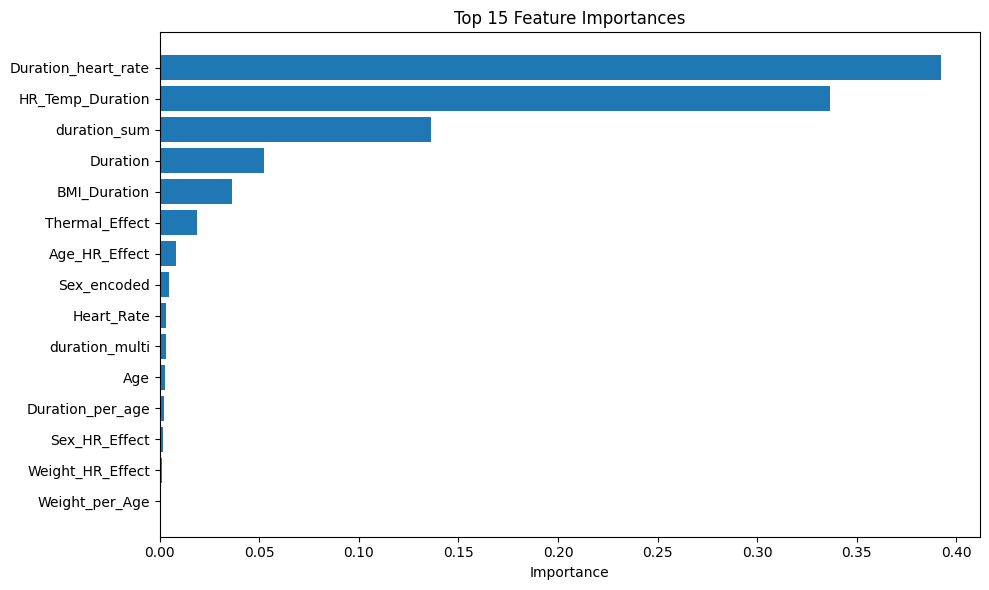

In [26]:
pd.set_option('display.max_rows', None)


xgb_model.fit(X_train, y_train)

# feature importances
feature_names = X_train.columns
importances = xgb_model.feature_importances_
feat_imp = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(feat_imp)

plt.figure(figsize=(10, 6))
plt.barh(feat_imp['Feature'][:15][::-1], feat_imp['Importance'][:15][::-1])
plt.xlabel('Importance')
plt.title('Top 15 Feature Importances')
plt.tight_layout()
plt.show()

Cross-Validation RMSLE: 0.060307


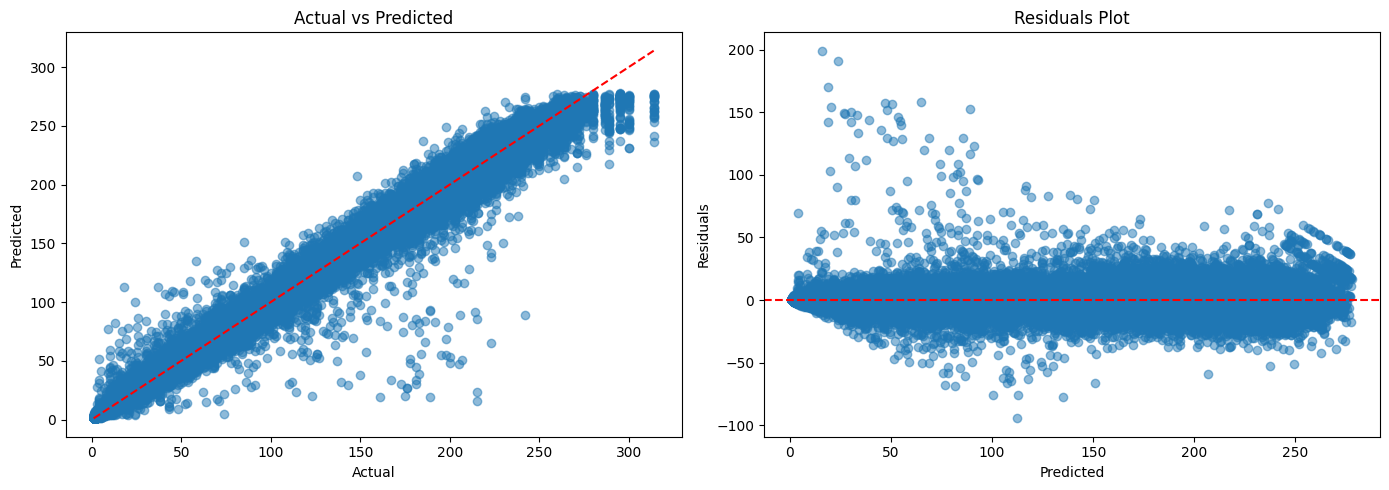

In [27]:
rmsle = evaluate_with_log_transform(xgb_model, X_train, y_train, cv=5)

In [28]:
# optimal feature selection

X_train_selected, selected_features = select_optimal_features(X_train, y_train, threshold=0.001)
train_final_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]
train_final_selected.index = X_train.index
X_train_selected = pd.DataFrame(X_train_selected, columns=selected_features)

Selected 9 out of 22 features
RFECV selected 16 features


Cross-Validation RMSLE: 0.060570


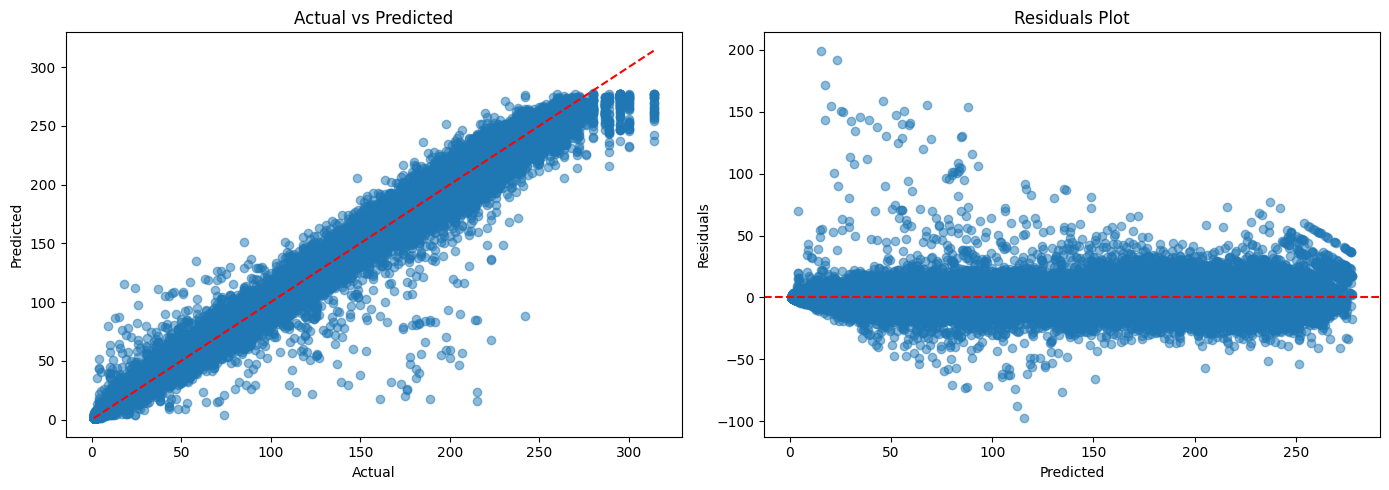

In [29]:
rmsle = evaluate_with_log_transform(xgb_model, X_train_selected, y_train, cv=5)

In [30]:
def train_with_log_transform(model, X_train, y_train, X_test):
    """
    Train model dengan log transform pada target variable,
    dan transformasi balik saat prediksi
    """
    # Clone model untuk memastikan kita menggunakan instance baru
    model_clone = clone(model)
    
    # Log transform target
    y_train_log = np.log1p(y_train)
    
    # Fit model dengan target yang sudah ditransformasi
    print("Training model dengan log-transformed target...")
    model_clone.fit(X_train, y_train_log)
    
    # Prediksi dalam log space
    print("Predicting...")
    log_preds_test = model_clone.predict(X_test)
    
    # Transform kembali ke original space
    predictions = np.expm1(log_preds_test)
    
    # Pastikan tidak ada nilai negatif atau nol (untuk RMSLE)
    predictions = np.maximum(predictions, 1e-15)
    
    # Validate on training data
    log_preds_train = model_clone.predict(X_train)
    train_predictions = np.expm1(log_preds_train)
    train_predictions = np.maximum(train_predictions, 1e-15)
    
    # Calculate training RMSLE
    train_rmsle = np.sqrt(mean_squared_log_error(y_train, train_predictions))
    print(f"Training RMSLE: {train_rmsle:.6f}")
    
    return model_clone, predictions, train_rmsle

Training model dengan log-transformed target...
Predicting...
Training RMSLE: 0.057817

Validasi dengan cross-validation:
Cross-Validation RMSLE: 0.060307


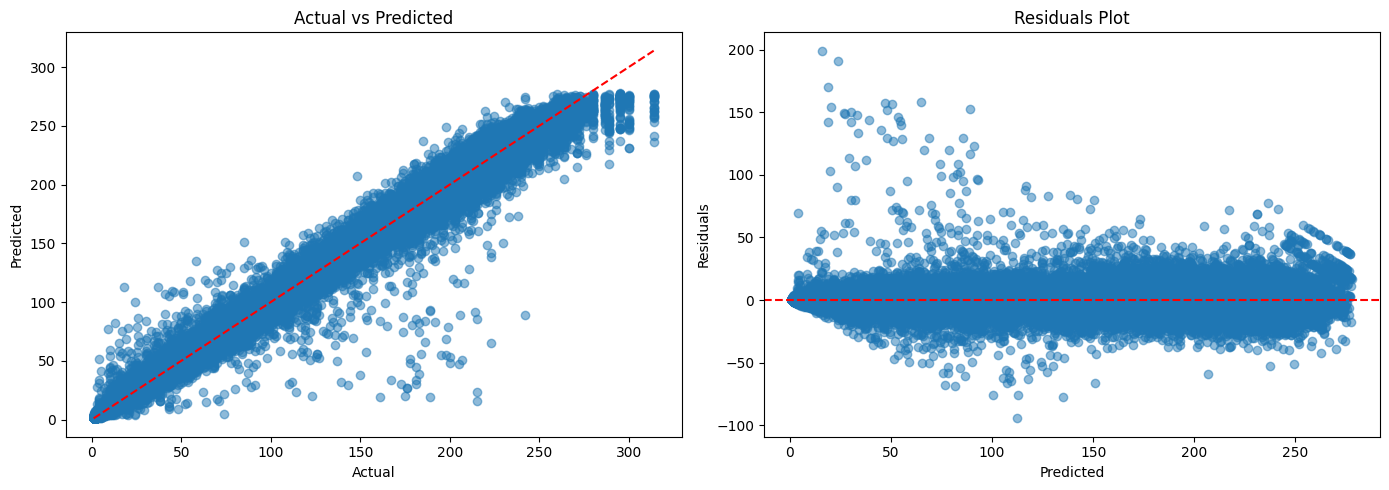


Training RMSLE: 0.057817
Cross-validation RMSLE: 0.060307
Perbedaan: 0.002491


In [31]:
# Training dengan log transform
log_transform_model, log_transform_predictions, train_rmsle = train_with_log_transform(
    xgb_model, X_train, y_train, X_test
)

# Bandingkan dengan cross-validation untuk memastikan model tidak overfitting
print("\nValidasi dengan cross-validation:")
cv_rmsle = evaluate_with_log_transform(xgb_model, X_train, y_train, cv=5)

print(f"\nTraining RMSLE: {train_rmsle:.6f}")
print(f"Cross-validation RMSLE: {cv_rmsle:.6f}")
print(f"Perbedaan: {abs(train_rmsle - cv_rmsle):.6f}")

# Submission

In [32]:
def make_submisson():
    output = pd.DataFrame({'id': X_test.index, 'Calories': log_transform_predictions})
    output.to_csv('output/submission5.csv', index=False)
    print("Your submission was successfully saved!")

In [33]:
make_submisson()

Your submission was successfully saved!
